In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load parquet file
df = pd.read_parquet(
    r"Data/delivery_sh-00000-of-00001-ad9a4b1d79823540.parquet"
)  # Shanghai dataset

"""
    LaDe is a publicly available last-mile delivery dataset with millions of packages from industry. 
    It has three unique characteristics: 
    (1) Large-scale. It involves 10,677k packages of 21k couriers over 6 months of real-world operation.
    (2) Comprehensive information, it offers original package information, 
    such as its location and time requirements, as well as task-event information, 
    which records when and where the courier is while events such as task-accept and task-finish events happen. 
    (3) Diversity: the dataset includes data from various scenarios, such as package pick-up and delivery, and from multiple cities, each with its unique spatio-temporal patterns due to their distinct characteristics such as populations.
    ## In this case we are using Shanghai dataset 1.4 million(2023, 6 months) observations
"""
df.tail(20)
# df["courier_id"].nunique()  # 1.7k unique couriers
# df["aoi_id"].nunique()  # 1.7k unique couriers
# df.dtypes # datatype
# df.columns
# df.shape # MM1.4 observations, 17 variables

,order_id,region_id,city,courier_id,lng,lat,aoi_id,aoi_type,accept_time,accept_gps_time,accept_gps_lng,accept_gps_lat,delivery_time,delivery_gps_time,delivery_gps_lng,delivery_gps_lat,ds
1483844,4269894,93,Shanghai,2690,121.55579,31.07875,60110,14,10-28 14:30:00,10-28 14:30:00,121.52740,31.06046,10-28 15:23:00,10-28 15:23:00,121.55658,31.07805,1028
1483845,3544229,93,Shanghai,2690,121.55570,31.07868,60110,14,10-30 12:39:00,10-30 12:39:00,121.52732,31.06046,10-30 13:16:00,10-30 13:16:00,121.55562,31.07823,1030
1483846,4421105,93,Shanghai,2690,121.55576,31.07876,60110,14,10-17 09:47:00,10-17 09:47:00,121.52749,31.06054,10-17 10:45:00,10-17 10:45:00,121.55660,31.07866,1017
1483847,1755872,93,Shanghai,2690,121.55550,31.07807,60110,14,10-12 11:31:00,10-12 11:31:00,121.52745,31.06043,10-12 12:02:00,10-12 12:02:00,121.54892,31.06934,1012
1483848,3507540,93,Shanghai,2690,121.55579,31.07869,60110,14,10-12 11:24:00,10-12 11:24:00,121.52732,31.06055,10-12 12:32:00,10-12 12:32:00,121.55537,31.07864,1012
1483849,3767553,93,Shanghai,2690,121.55572,31.07868,60110,14,10-23 12:38:00,10-23 12:38:00,121.52746,31.06055,10-23 14:20:00,10-23 14:20:00,121.56184,31.07856,1023
1483850,4133337,93,Shanghai,2690,121.55546,31.07801,60110,14,10-14 15:26:00,10-14 15:26:00,121.52734,31.06057,10-14 17:02:00,10-14 17:02:00,121.56006,31.07914,1014
1483851,3366342,93,Shanghai,2690,121.55570,31.07871,60110,14,10-15 14:57:00,10-15 14:57:00,121.52734,31.06050,10-15 15:58:00,10-15 15:58:00,121.55748,31.07812,1015
1483852,4503429,93,Shanghai,2690,121.55566,31.07864,60110,14,10-14 15:27:00,10-14 15:27:00,121.52741,31.06047,10-14 16:47:00,10-14 16:47:00,121.55700,31.07813,1014
1483853,772105,93,Shanghai,2690,121.55550,31.07812,60110,14,10-15 14:59:00,10-15 14:59:00,121.52737,31.06057,10-15 17:00:00,10-15 17:00:00,121.54025,31.06631,1015


In [4]:
# Haversine Distance between pickup and delivery points
from geopy.distance import geodesic


def haversine_distance(row):
    try:
        start = (row["accept_gps_lat"], row["accept_gps_lng"])
        end = (row["delivery_gps_lat"], row["delivery_gps_lng"])
        if (
            pd.notna(start[0])
            and pd.notna(start[1])
            and pd.notna(end[0])
            and pd.notna(end[1])
        ):
            return geodesic(start, end).km
        else:
            return np.nan
    except:
        return np.nan


df["distance_km"] = df.apply(haversine_distance, axis=1)
df.head(5)

,order_id,region_id,city,courier_id,lng,lat,aoi_id,aoi_type,accept_time,accept_gps_time,accept_gps_lng,accept_gps_lat,delivery_time,delivery_gps_time,delivery_gps_lng,delivery_gps_lat,ds,distance_km
0,3158819,1,Shanghai,164,121.52128,31.06614,450,1,06-04 11:05:00,06-04 11:05:00,121.52281,31.10598,06-04 17:40:00,06-04 17:40:00,121.52407,31.06614,604,4.418734
1,751342,1,Shanghai,164,121.52124,31.06687,450,1,06-04 11:18:00,06-04 11:18:00,121.52286,31.10599,06-04 15:06:00,06-04 15:06:00,121.52412,31.06618,604,4.415409
2,3380476,1,Shanghai,164,121.52106,31.06731,450,1,06-03 10:13:00,06-03 10:13:00,121.52285,31.10591,06-03 15:11:00,06-03 15:11:00,121.52059,31.06672,603,4.350380
3,2184571,1,Shanghai,164,121.52128,31.06616,450,1,06-04 10:39:00,06-04 10:39:00,121.52282,31.10593,06-04 15:41:00,06-04 15:41:00,121.52280,31.10542,604,0.056577
4,941371,1,Shanghai,164,121.52123,31.06614,450,1,06-04 11:18:00,06-04 11:18:00,121.52285,31.10593,06-04 14:07:00,06-04 14:07:00,121.52290,31.06758,604,4.251904


In [5]:
df.info()  # check for null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483864 entries, 0 to 1483863
Data columns (total 18 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   order_id           1483864 non-null  int64  
 1   region_id          1483864 non-null  int64  
 2   city               1483864 non-null  object 
 3   courier_id         1483864 non-null  int64  
 4   lng                1483864 non-null  float64
 5   lat                1483864 non-null  float64
 6   aoi_id             1483864 non-null  int64  
 7   aoi_type           1483864 non-null  int64  
 8   accept_time        1483864 non-null  object 
 9   accept_gps_time    1483864 non-null  object 
 10  accept_gps_lng     1483864 non-null  float64
 11  accept_gps_lat     1483864 non-null  float64
 12  delivery_time      1483864 non-null  object 
 13  delivery_gps_time  1483864 non-null  object 
 14  delivery_gps_lng   1483864 non-null  float64
 15  delivery_gps_lat   1483864 non-n

In [6]:
df

,order_id,region_id,city,courier_id,lng,lat,aoi_id,aoi_type,accept_time,accept_gps_time,accept_gps_lng,accept_gps_lat,delivery_time,delivery_gps_time,delivery_gps_lng,delivery_gps_lat,ds,distance_km
0,3158819,1,Shanghai,164,121.52128,31.06614,450,1,06-04 11:05:00,06-04 11:05:00,121.52281,31.10598,06-04 17:40:00,06-04 17:40:00,121.52407,31.06614,604,4.418734
1,751342,1,Shanghai,164,121.52124,31.06687,450,1,06-04 11:18:00,06-04 11:18:00,121.52286,31.10599,06-04 15:06:00,06-04 15:06:00,121.52412,31.06618,604,4.415409
2,3380476,1,Shanghai,164,121.52106,31.06731,450,1,06-03 10:13:00,06-03 10:13:00,121.52285,31.10591,06-03 15:11:00,06-03 15:11:00,121.52059,31.06672,603,4.350380
3,2184571,1,Shanghai,164,121.52128,31.06616,450,1,06-04 10:39:00,06-04 10:39:00,121.52282,31.10593,06-04 15:41:00,06-04 15:41:00,121.52280,31.10542,604,0.056577
4,941371,1,Shanghai,164,121.52123,31.06614,450,1,06-04 11:18:00,06-04 11:18:00,121.52285,31.10593,06-04 14:07:00,06-04 14:07:00,121.52290,31.06758,604,4.251904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483859,960937,93,Shanghai,2690,121.55559,31.07807,60110,14,10-22 13:28:00,10-22 13:28:00,121.52749,31.06045,10-22 16:37:00,10-22 16:37:00,121.56303,31.07953,1022,3.997358
1483860,3894541,93,Shanghai,2690,121.55567,31.07864,60110,14,10-21 13:53:00,10-21 13:53:00,121.52737,31.06047,10-21 14:21:00,10-21 14:21:00,121.55509,31.07841,1021,3.309780
1483861,3946912,93,Shanghai,2690,121.55574,31.07873,60110,14,10-20 08:56:00,10-20 08:56:00,121.52742,31.06046,10-20 09:12:00,10-20 09:12:00,121.55703,31.07842,1020,3.456926
1483862,1320044,93,Shanghai,2690,121.55565,31.07866,60110,14,10-18 15:07:00,10-18 15:07:00,121.52732,31.06045,10-18 16:54:00,10-18 16:54:00,121.55643,31.08042,1018,3.552454


In [7]:
df

,order_id,region_id,city,courier_id,lng,lat,aoi_id,aoi_type,accept_time,accept_gps_time,accept_gps_lng,accept_gps_lat,delivery_time,delivery_gps_time,delivery_gps_lng,delivery_gps_lat,ds,distance_km
0,3158819,1,Shanghai,164,121.52128,31.06614,450,1,06-04 11:05:00,06-04 11:05:00,121.52281,31.10598,06-04 17:40:00,06-04 17:40:00,121.52407,31.06614,604,4.418734
1,751342,1,Shanghai,164,121.52124,31.06687,450,1,06-04 11:18:00,06-04 11:18:00,121.52286,31.10599,06-04 15:06:00,06-04 15:06:00,121.52412,31.06618,604,4.415409
2,3380476,1,Shanghai,164,121.52106,31.06731,450,1,06-03 10:13:00,06-03 10:13:00,121.52285,31.10591,06-03 15:11:00,06-03 15:11:00,121.52059,31.06672,603,4.350380
3,2184571,1,Shanghai,164,121.52128,31.06616,450,1,06-04 10:39:00,06-04 10:39:00,121.52282,31.10593,06-04 15:41:00,06-04 15:41:00,121.52280,31.10542,604,0.056577
4,941371,1,Shanghai,164,121.52123,31.06614,450,1,06-04 11:18:00,06-04 11:18:00,121.52285,31.10593,06-04 14:07:00,06-04 14:07:00,121.52290,31.06758,604,4.251904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483859,960937,93,Shanghai,2690,121.55559,31.07807,60110,14,10-22 13:28:00,10-22 13:28:00,121.52749,31.06045,10-22 16:37:00,10-22 16:37:00,121.56303,31.07953,1022,3.997358
1483860,3894541,93,Shanghai,2690,121.55567,31.07864,60110,14,10-21 13:53:00,10-21 13:53:00,121.52737,31.06047,10-21 14:21:00,10-21 14:21:00,121.55509,31.07841,1021,3.309780
1483861,3946912,93,Shanghai,2690,121.55574,31.07873,60110,14,10-20 08:56:00,10-20 08:56:00,121.52742,31.06046,10-20 09:12:00,10-20 09:12:00,121.55703,31.07842,1020,3.456926
1483862,1320044,93,Shanghai,2690,121.55565,31.07866,60110,14,10-18 15:07:00,10-18 15:07:00,121.52732,31.06045,10-18 16:54:00,10-18 16:54:00,121.55643,31.08042,1018,3.552454


In [8]:
# Data Formatting

# formatting time
df["accept_time"] = pd.to_datetime(
    df["accept_time"], format="%m-%d %H:%M:%S", errors="coerce"
)
df["delivery_time"] = pd.to_datetime(
    df["delivery_time"], format="%m-%d %H:%M:%S", errors="coerce"
)
df["accept_gps_time"] = pd.to_datetime(
    df["accept_gps_time"], format="%m-%d %H:%M:%S", errors="coerce"
)
df["delivery_gps_time"] = pd.to_datetime(
    df["delivery_gps_time"], format="%m-%d %H:%M:%S", errors="coerce"
)

# allocating 2023 year to the time
df["accept_time"] = df["accept_time"].apply(
    lambda x: x.replace(year=2023) if pd.notna(x) else x
)
df["delivery_time"] = df["delivery_time"].apply(
    lambda x: x.replace(year=2023) if pd.notna(x) else x
)
df["accept_gps_time"] = df["accept_gps_time"].apply(
    lambda x: x.replace(year=2023) if pd.notna(x) else x
)
df["delivery_gps_time"] = df["delivery_gps_time"].apply(
    lambda x: x.replace(year=2023) if pd.notna(x) else x
)

print(
    df[["accept_time", "delivery_time", "accept_gps_time", "delivery_gps_time"]].head()
)

          accept_time       delivery_time     accept_gps_time  \
0 2023-06-04 11:05:00 2023-06-04 17:40:00 2023-06-04 11:05:00   
1 2023-06-04 11:18:00 2023-06-04 15:06:00 2023-06-04 11:18:00   
2 2023-06-03 10:13:00 2023-06-03 15:11:00 2023-06-03 10:13:00   
3 2023-06-04 10:39:00 2023-06-04 15:41:00 2023-06-04 10:39:00   
4 2023-06-04 11:18:00 2023-06-04 14:07:00 2023-06-04 11:18:00   

    delivery_gps_time  
0 2023-06-04 17:40:00  
1 2023-06-04 15:06:00  
2 2023-06-03 15:11:00  
3 2023-06-04 15:41:00  
4 2023-06-04 14:07:00  


In [9]:
"""
1. Delivery time distribution analysis
"""

# Delivery Time Analysis
df["delivery_duration"] = df["delivery_time"] - df["accept_time"]
df["delivery_duration_minutes"] = df["delivery_duration"].dt.total_seconds() / 60
df[
    "delivery_duration_minutes"
].describe()  # Max is 47,739 minutes!? = 33days? I guess it's an outlier

count    1.483864e+06
mean     1.111406e+02
std      2.191312e+02
min      0.000000e+00
25%      4.300000e+01
50%      7.200000e+01
75%      1.190000e+02
max      4.773900e+04
Name: delivery_duration_minutes, dtype: float64

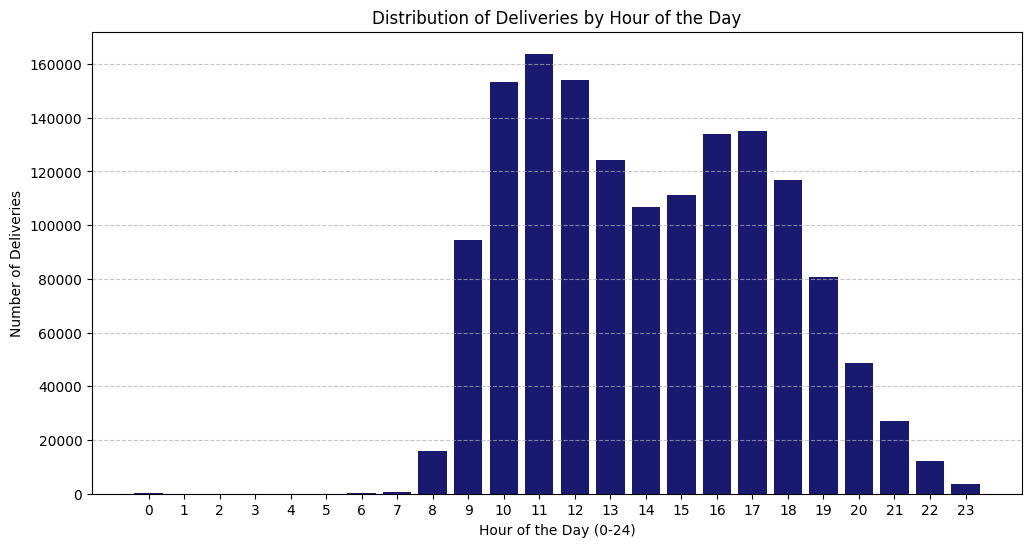

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df["delivery_hour"] = df["delivery_time"].dt.hour
hourly_distribution = df["delivery_hour"].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(hourly_distribution.index, hourly_distribution.values, color="midnightblue")

# Labels and title
plt.xlabel("Hour of the Day (0-24)")
plt.ylabel("Number of Deliveries")
plt.title("Distribution of Deliveries by Hour of the Day")
plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

## EDA

In [11]:
df["accept_hour"] = df["accept_time"].dt.hour

In [12]:
df

,order_id,region_id,city,courier_id,lng,lat,aoi_id,aoi_type,accept_time,accept_gps_time,...,delivery_time,delivery_gps_time,delivery_gps_lng,delivery_gps_lat,ds,distance_km,delivery_duration,delivery_duration_minutes,delivery_hour,accept_hour
0,3158819,1,Shanghai,164,121.52128,31.06614,450,1,2023-06-04 11:05:00,2023-06-04 11:05:00,...,2023-06-04 17:40:00,2023-06-04 17:40:00,121.52407,31.06614,604,4.418734,0 days 06:35:00,395.0,17,11
1,751342,1,Shanghai,164,121.52124,31.06687,450,1,2023-06-04 11:18:00,2023-06-04 11:18:00,...,2023-06-04 15:06:00,2023-06-04 15:06:00,121.52412,31.06618,604,4.415409,0 days 03:48:00,228.0,15,11
2,3380476,1,Shanghai,164,121.52106,31.06731,450,1,2023-06-03 10:13:00,2023-06-03 10:13:00,...,2023-06-03 15:11:00,2023-06-03 15:11:00,121.52059,31.06672,603,4.350380,0 days 04:58:00,298.0,15,10
3,2184571,1,Shanghai,164,121.52128,31.06616,450,1,2023-06-04 10:39:00,2023-06-04 10:39:00,...,2023-06-04 15:41:00,2023-06-04 15:41:00,121.52280,31.10542,604,0.056577,0 days 05:02:00,302.0,15,10
4,941371,1,Shanghai,164,121.52123,31.06614,450,1,2023-06-04 11:18:00,2023-06-04 11:18:00,...,2023-06-04 14:07:00,2023-06-04 14:07:00,121.52290,31.06758,604,4.251904,0 days 02:49:00,169.0,14,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483859,960937,93,Shanghai,2690,121.55559,31.07807,60110,14,2023-10-22 13:28:00,2023-10-22 13:28:00,...,2023-10-22 16:37:00,2023-10-22 16:37:00,121.56303,31.07953,1022,3.997358,0 days 03:09:00,189.0,16,13
1483860,3894541,93,Shanghai,2690,121.55567,31.07864,60110,14,2023-10-21 13:53:00,2023-10-21 13:53:00,...,2023-10-21 14:21:00,2023-10-21 14:21:00,121.55509,31.07841,1021,3.309780,0 days 00:28:00,28.0,14,13
1483861,3946912,93,Shanghai,2690,121.55574,31.07873,60110,14,2023-10-20 08:56:00,2023-10-20 08:56:00,...,2023-10-20 09:12:00,2023-10-20 09:12:00,121.55703,31.07842,1020,3.456926,0 days 00:16:00,16.0,9,8
1483862,1320044,93,Shanghai,2690,121.55565,31.07866,60110,14,2023-10-18 15:07:00,2023-10-18 15:07:00,...,2023-10-18 16:54:00,2023-10-18 16:54:00,121.55643,31.08042,1018,3.552454,0 days 01:47:00,107.0,16,15


### Aggregating data for courier ids
Just wondering should we group our data fixing for aoi id and region id as well? Because if we didn't do them, the average duration will be the same for all of the observation when we merge it with the original data.

In [14]:
agg_df_simple = (
    df.groupby(["courier_id", "ds"])
    .agg(
        task_count=("order_id", "count"),
        avg_delivery_duration_min=("delivery_duration_minutes", "mean"),
        avg_distance_km=("distance_km", "mean"),
        # region_id=("region_id", "first"),
        # aoi_id=("aoi_id", "first"),  # first AOI ID for the courier
        delivery_hour_mode=(  # most common time of day that deliveries accepted
            "accept_hour",
            lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
        ),
        # suffixes="_agg",
    )
    .reset_index()
)

agg_df_simple

,courier_id,ds,task_count,avg_delivery_duration_min,avg_distance_km,delivery_hour_mode
0,0,620,1,120.000000,0.022558,16
1,0,726,7,121.857143,1.272034,9
2,0,727,9,103.888889,1.124875,10
3,1,503,1,314.000000,1.279976,16
4,1,504,1,323.000000,1.270673,17
...,...,...,...,...,...,...
70248,4874,1026,31,171.612903,2.810233,13
70249,4874,1027,57,190.070175,2.440456,8
70250,4874,1028,24,137.333333,542.920910,9
70251,4874,1029,36,189.111111,2.800309,13


### Merge dataset with grouped df

In [16]:
df_merged = df.merge(agg_df_simple, on=["courier_id", "ds"], how="left")
df_merged

,order_id,region_id,city,courier_id,lng,lat,aoi_id,aoi_type,accept_time,accept_gps_time,...,ds,distance_km,delivery_duration,delivery_duration_minutes,delivery_hour,accept_hour,task_count,avg_delivery_duration_min,avg_distance_km,delivery_hour_mode
0,3158819,1,Shanghai,164,121.52128,31.06614,450,1,2023-06-04 11:05:00,2023-06-04 11:05:00,...,604,4.418734,0 days 06:35:00,395.0,17,11,29,180.241379,3.824197,11
1,751342,1,Shanghai,164,121.52124,31.06687,450,1,2023-06-04 11:18:00,2023-06-04 11:18:00,...,604,4.415409,0 days 03:48:00,228.0,15,11,29,180.241379,3.824197,11
2,3380476,1,Shanghai,164,121.52106,31.06731,450,1,2023-06-03 10:13:00,2023-06-03 10:13:00,...,603,4.350380,0 days 04:58:00,298.0,15,10,23,302.217391,3.971897,10
3,2184571,1,Shanghai,164,121.52128,31.06616,450,1,2023-06-04 10:39:00,2023-06-04 10:39:00,...,604,0.056577,0 days 05:02:00,302.0,15,10,29,180.241379,3.824197,11
4,941371,1,Shanghai,164,121.52123,31.06614,450,1,2023-06-04 11:18:00,2023-06-04 11:18:00,...,604,4.251904,0 days 02:49:00,169.0,14,11,29,180.241379,3.824197,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483859,960937,93,Shanghai,2690,121.55559,31.07807,60110,14,2023-10-22 13:28:00,2023-10-22 13:28:00,...,1022,3.997358,0 days 03:09:00,189.0,16,13,38,104.157895,2.007892,13
1483860,3894541,93,Shanghai,2690,121.55567,31.07864,60110,14,2023-10-21 13:53:00,2023-10-21 13:53:00,...,1021,3.309780,0 days 00:28:00,28.0,14,13,26,86.500000,1.925849,13
1483861,3946912,93,Shanghai,2690,121.55574,31.07873,60110,14,2023-10-20 08:56:00,2023-10-20 08:56:00,...,1020,3.456926,0 days 00:16:00,16.0,9,8,23,86.565217,1.963672,10
1483862,1320044,93,Shanghai,2690,121.55565,31.07866,60110,14,2023-10-18 15:07:00,2023-10-18 15:07:00,...,1018,3.552454,0 days 01:47:00,107.0,16,15,23,59.347826,1.945302,13


 ### Remove outliers to make plotting easier and more readable

In [ ]:
duration_cap = df_merged["avg_delivery_duration_min"].quantile(0.99)
distance_cap = df_merged["avg_distance_km"].quantile(0.99)

df_filtered = df_merged[
    (df_merged["avg_delivery_duration_min"] <= duration_cap)
    & (df_merged["avg_distance_km"] <= distance_cap)
]

### 1. Histogram of avg delivery duration

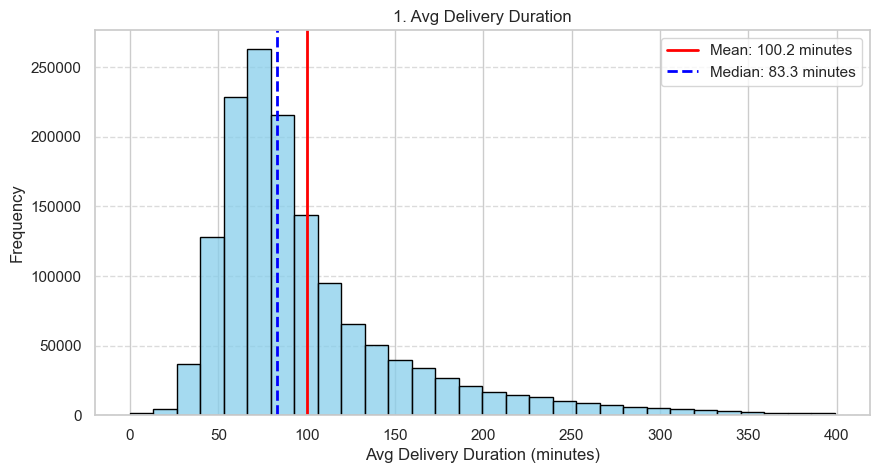

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
median_duration = df_filtered["avg_delivery_duration_min"].median()

mean_duration = df_filtered["avg_delivery_duration_min"].mean()

plt.figure(figsize=(10, 5))
sns.histplot(
    df_filtered["avg_delivery_duration_min"],
    bins=30,
    color="skyblue",
    edgecolor="black",
)
plt.axvline(
    mean_duration,
    color="red",
    linestyle="solid",
    linewidth=2,
    label=f"Mean: {mean_duration:.1f} minutes",
)

plt.axvline(
    median_duration,
    color="blue",
    linestyle="dashed",
    linewidth=2,
    label=f"Median: {median_duration:.1f} minutes",
)
plt.title("1. Avg Delivery Duration")
plt.xlabel("Avg Delivery Duration (minutes)")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()

> Most delivery durations fall between 50 to 120 minutes, with a long right tail. This skewness justifies considering log transformation or robust methods in regression.

### 2. Histogram of avg delivery distance


In [154]:
df_filtered

,order_id,region_id,city,courier_id,lng,lat,aoi_id,aoi_type,accept_time,accept_gps_time,...,ds,distance_km,delivery_duration,delivery_duration_minutes,delivery_hour,accept_hour,task_count,avg_delivery_duration_min,avg_distance_km,delivery_hour_mode
0,3158819,1,Shanghai,164,121.52128,31.06614,450,1,2023-06-04 11:05:00,2023-06-04 11:05:00,...,604,4.418734,0 days 06:35:00,395.0,17,11,29,180.241379,3.824197,11
1,751342,1,Shanghai,164,121.52124,31.06687,450,1,2023-06-04 11:18:00,2023-06-04 11:18:00,...,604,4.415409,0 days 03:48:00,228.0,15,11,29,180.241379,3.824197,11
2,3380476,1,Shanghai,164,121.52106,31.06731,450,1,2023-06-03 10:13:00,2023-06-03 10:13:00,...,603,4.350380,0 days 04:58:00,298.0,15,10,23,302.217391,3.971897,10
3,2184571,1,Shanghai,164,121.52128,31.06616,450,1,2023-06-04 10:39:00,2023-06-04 10:39:00,...,604,0.056577,0 days 05:02:00,302.0,15,10,29,180.241379,3.824197,11
4,941371,1,Shanghai,164,121.52123,31.06614,450,1,2023-06-04 11:18:00,2023-06-04 11:18:00,...,604,4.251904,0 days 02:49:00,169.0,14,11,29,180.241379,3.824197,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483859,960937,93,Shanghai,2690,121.55559,31.07807,60110,14,2023-10-22 13:28:00,2023-10-22 13:28:00,...,1022,3.997358,0 days 03:09:00,189.0,16,13,38,104.157895,2.007892,13
1483860,3894541,93,Shanghai,2690,121.55567,31.07864,60110,14,2023-10-21 13:53:00,2023-10-21 13:53:00,...,1021,3.309780,0 days 00:28:00,28.0,14,13,26,86.500000,1.925849,13
1483861,3946912,93,Shanghai,2690,121.55574,31.07873,60110,14,2023-10-20 08:56:00,2023-10-20 08:56:00,...,1020,3.456926,0 days 00:16:00,16.0,9,8,23,86.565217,1.963672,10
1483862,1320044,93,Shanghai,2690,121.55565,31.07866,60110,14,2023-10-18 15:07:00,2023-10-18 15:07:00,...,1018,3.552454,0 days 01:47:00,107.0,16,15,23,59.347826,1.945302,13


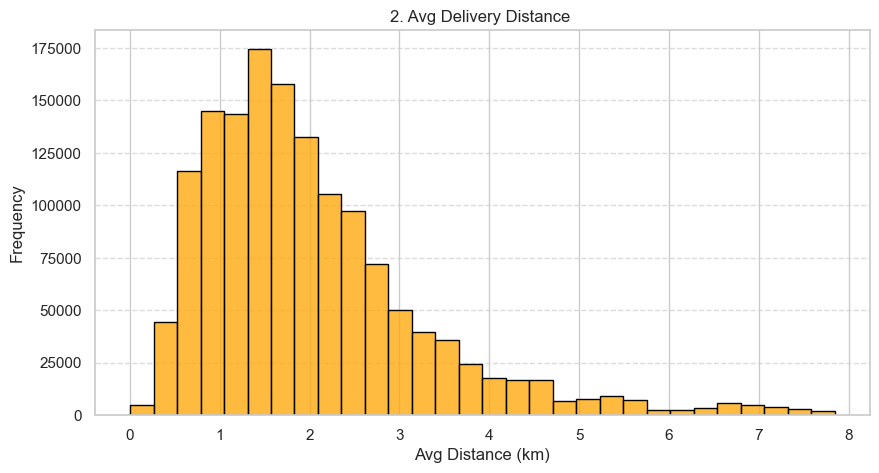

In [ ]:
plt.figure(figsize=(10, 5))


sns.histplot(df_filtered["avg_distance_km"], bins=30, color="orange", edgecolor="black")


plt.title("2. Avg Delivery Distance ")


plt.xlabel("Avg Distance (km)")


plt.ylabel("Frequency")


plt.grid(axis="y", linestyle="--", alpha=0.7)


plt.show()

> Most tasks are completed within 1–3 km, which means large distances are rare. Suggests that task clustering is geographically helpful. Still, controlling for avg_distance_km is crucial, since longer routes naturally take more time.

### 3. Scatter plot: task count vs avg delivery duration


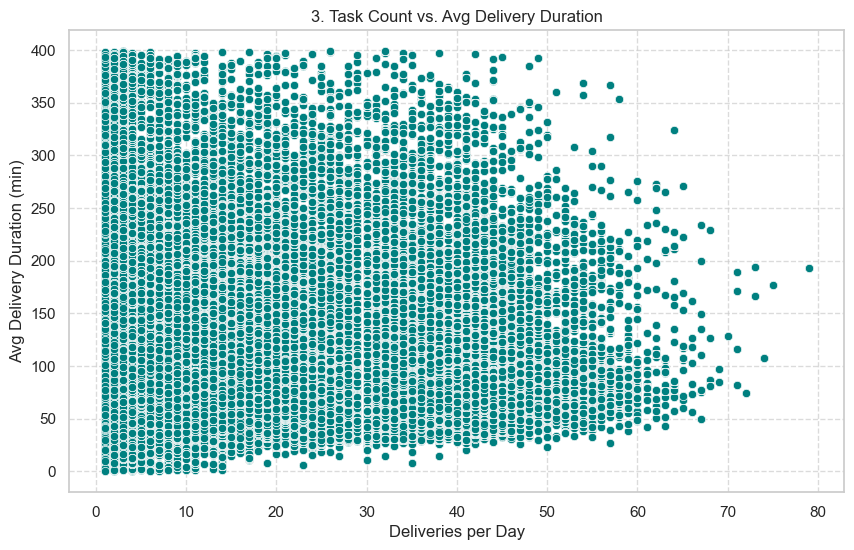

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_filtered, x="task_count", y="avg_delivery_duration_min", color="teal"
)
plt.title("3. Task Count vs. Avg Delivery Duration")
plt.xlabel("Deliveries per Day")
plt.ylabel("Avg Delivery Duration (min)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

> At a glance, higher task counts are associated with lower or more consistent average durations. Additionally, our data is not concentrated on higher deliveries so it's not straightforward to see the relationship. This suggests that task count alone is not linearly increasing delivery times, and other factors may be at play. We should consider using a more complex model to capture this relationship.

### 4. Avg delivery duration by region


C:\Users\Afag\AppData\Local\Temp\ipykernel_25416\2886091224.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_means.index.astype(str), y=region_means.values, palette="magma")


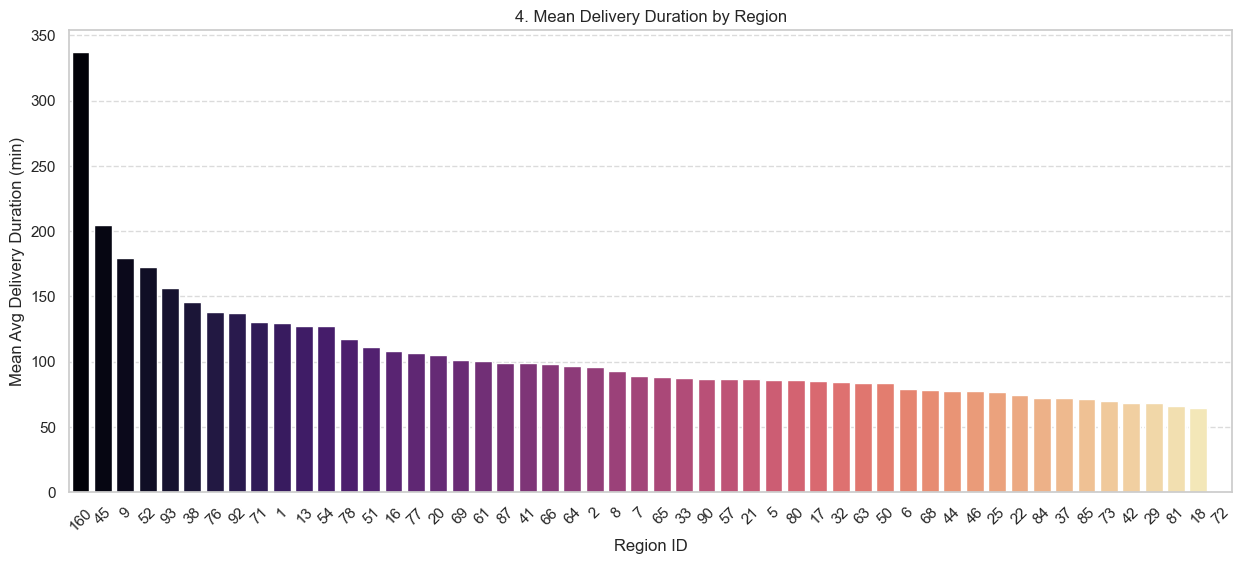

In [ ]:
# plt.figure(figsize=(14, 6))
# sns.boxplot(
#     data=df_filtered, x="region_id", y="avg_delivery_duration_min", palette="Blues_r"
# )
# plt.title("4. Avg Delivery Duration by Region")
# plt.xlabel("Region ID")
# plt.ylabel("Avg Delivery Duration (min)")
# plt.xticks(rotation=90)
# plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.show()

plt.figure(figsize=(15, 6))
region_means = (
    df_filtered.groupby("region_id")["avg_delivery_duration_min"]
    .mean()
    .sort_values(ascending=False)
)
sns.barplot(x=region_means.index.astype(str), y=region_means.values, palette="magma")
plt.title("4. Mean Delivery Duration by Region")
plt.xlabel("Region ID")
plt.ylabel("Mean Avg Delivery Duration (min)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

> Delivery time varies significantly by region_id, with some areas averaging over 300+ minutes per task. Reinforces the need to include region fixed effects in the regression.  Some regions may have worse traffic, longer parking walking time, or organizational inefficiencies.

#### 4.1 Number of deliveries by region

C:\Users\Afag\AppData\Local\Temp\ipykernel_25416\2927117715.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


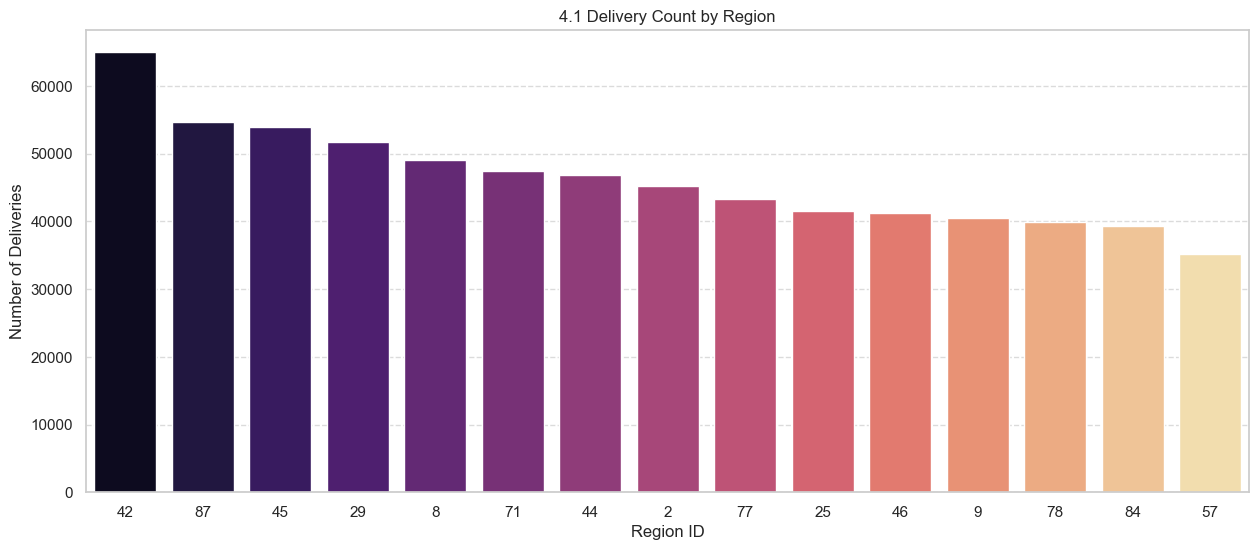

In [135]:
plt.figure(figsize=(15, 6))
region_means = (
    df.groupby("region_id")
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
    .head(15)
)

sns.barplot(
    x=region_means["region_id"].astype(str), y=region_means["count"], palette="magma"
)
plt.title("4.1 Delivery Count by Region")
plt.xlabel("Region ID")
plt.ylabel("Number of Deliveries")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

So above trend is not followed by the delivery count. Some regions have high delivery counts but low average durations, while others have low counts but high durations. This suggests that some regions my have high frequency of deliveries which leads to lower average delivery duration. Maybe we need to find **weighted average of delivery duration by region_id and delivery count.**

### 5. Avg Delivery Duration by Most Frequent Accept Hour

C:\Users\Afag\AppData\Local\Temp\ipykernel_25416\1595642105.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


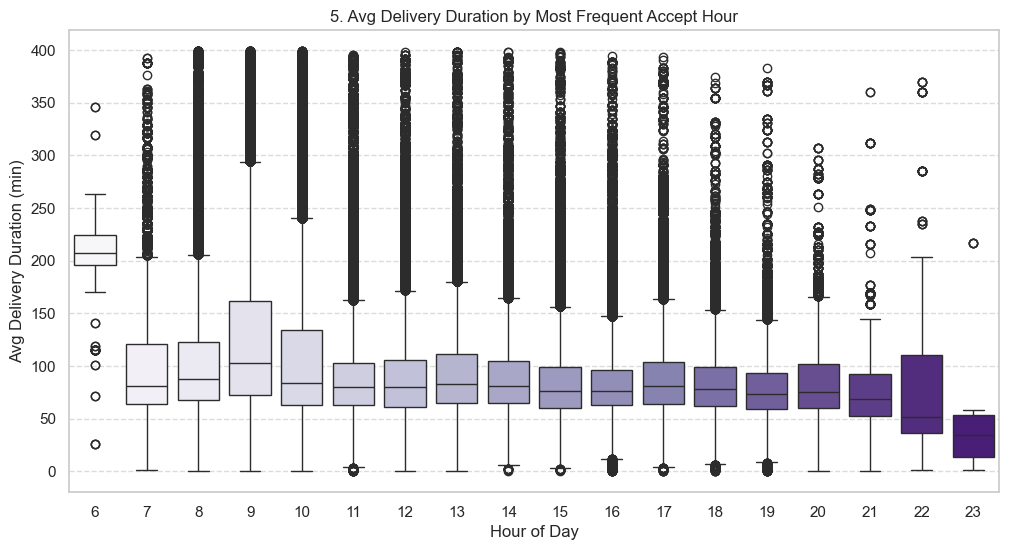

In [133]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_filtered,
    x="delivery_hour_mode",
    y="avg_delivery_duration_min",
    palette="Purples",
)
plt.title("5. Avg Delivery Duration by Most Frequent Accept Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Delivery Duration (min)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

> Median delivery times tend to decline as the day progresses. But early hours have wider spread and more high-end outliers. Suggests that early deliveries might include more complex tasks, or face morning congestion.


### 6. Number of Deliveries by Most Frequent Accept Hour
> The number of deliveries is highest in the late morning and early afternoon, with a significant drop-off in the evening. This suggests that most deliveries are concentrated during typical working hours, which may be due to customer demand patterns or operational constraints.

In [130]:
agg_df_simple

,courier_id,ds,task_count,avg_delivery_duration_min,avg_distance_km,delivery_hour_mode
0,0,620,1,120.000000,0.022558,16
1,0,726,7,121.857143,1.272034,9
2,0,727,9,103.888889,1.124875,10
3,1,503,1,314.000000,1.279976,16
4,1,504,1,323.000000,1.270673,17
...,...,...,...,...,...,...
70248,4874,1026,31,171.612903,2.810233,13
70249,4874,1027,57,190.070175,2.440456,8
70250,4874,1028,24,137.333333,542.920910,9
70251,4874,1029,36,189.111111,2.800309,13


C:\Users\Afag\AppData\Local\Temp\ipykernel_25416\3084455207.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hour_means.index.astype(str), y=hour_means.values, palette="magma")


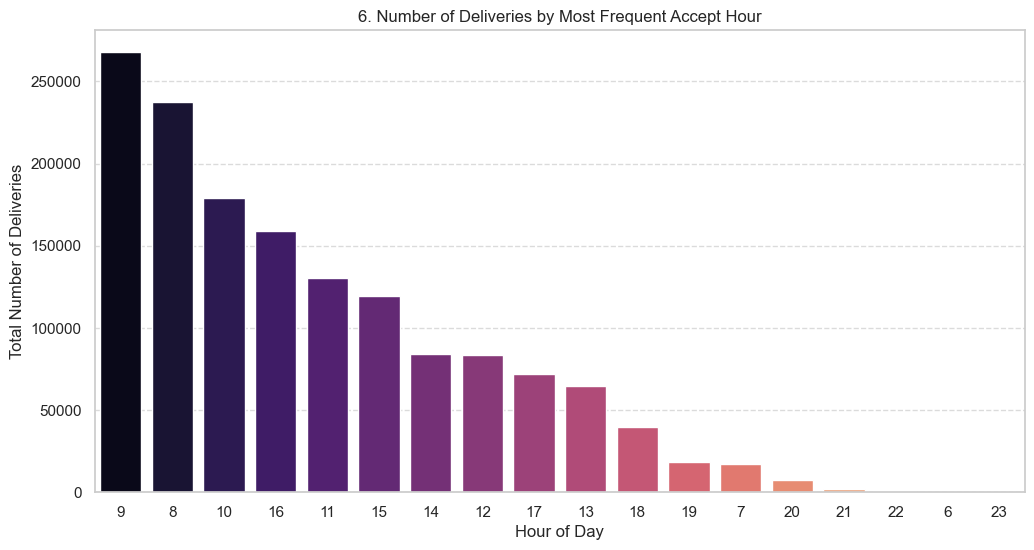

In [131]:
hour_means = (
    agg_df_simple.groupby("delivery_hour_mode")["task_count"]
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12, 6))
sns.barplot(x=hour_means.index.astype(str), y=hour_means.values, palette="magma")
plt.title("6. Number of Deliveries by Most Frequent Accept Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Total Number of Deliveries")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

> It justifies our finding we state about the above boxplot: longest tasks tend to occur early in the day.  The early morning and late evening hours have significantly fewer deliveries, indicating potential opportunities for optimization or expansion in those time slots. Useful to include delivery_hour_mode as a categorical control in the regression model. 

In [26]:
# df_filtered.to_parquet(r"data_after_merging_and_eda_not_filtered.parquet")

### 7. Delivery count by Courier ID

In [ ]:
courier_tasks_aggregated = (
    df_filtered.groupby("courier_id").agg({"task_count": sum}).reset_index()
)
courier_tasks_aggregated

C:\Users\Afag\AppData\Local\Temp\ipykernel_25416\2671609004.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  courier_tasks_aggregated = df_filtered.groupby("courier_id").agg({"task_count": sum}).reset_index()


,courier_id,task_count
0,0,131
1,1,110089
2,12,197326
3,13,9484
4,25,3239
...,...,...
1706,4861,2884
1707,4868,5597
1708,4869,67221
1709,4873,196


In [36]:
courier_tasks_aggregated.task_count.describe()

count      1711.000000
mean      26117.150789
std       48479.467419
min           1.000000
25%         259.000000
50%        2961.000000
75%       23407.500000
max      327070.000000
Name: task_count, dtype: float64

##### In total 855 Couriers out of 1711 have an aggregated task count of 2961(median) and more

In [ ]:
courier_tasks_aggregated[courier_tasks_aggregated["task_count"] > 2961].shape

(855, 2)

##### In total 405 Couriers have an aggregated task count of 26117(mean) and more

In [ ]:
courier_tasks_aggregated[courier_tasks_aggregated["task_count"] > 26117].shape

(405, 2)

C:\Users\Afag\AppData\Local\Temp\ipykernel_25416\4178408976.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index.astype(str), y=count.values, palette="magma")


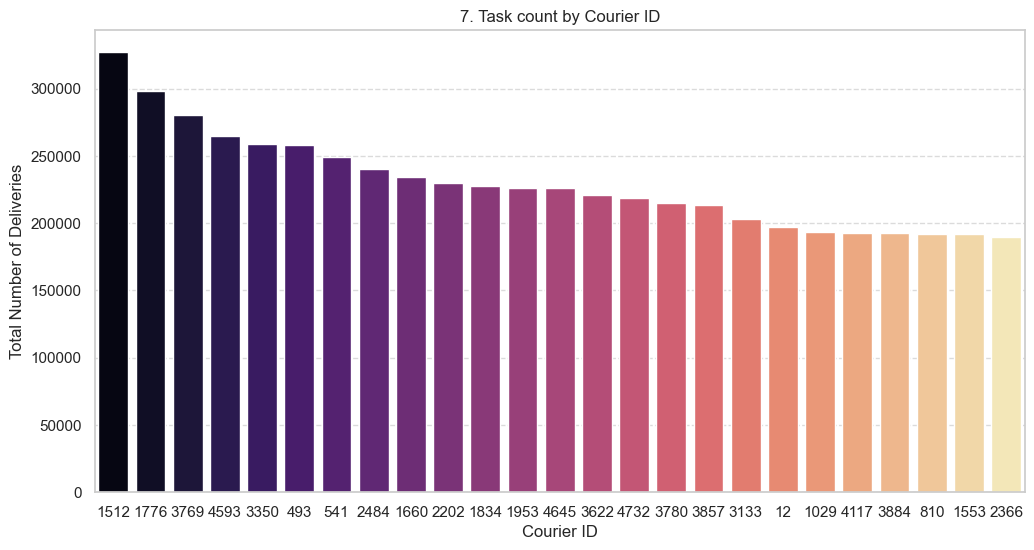

In [ ]:
count = (
    df_filtered.groupby("courier_id")["task_count"]
    .sum()
    .sort_values(ascending=False)
    .head(25)
)

count
plt.figure(figsize=(12, 6))
sns.barplot(x=count.index.astype(str), y=count.values, palette="magma")
plt.title("7. Task count by Courier ID")
plt.xlabel("Courier ID")
plt.ylabel("Total Number of Deliveries")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### 7. Additional EDA (Courier IDs per region or AOI)
- Considering # of Courier IDs, Grouping by ***region ID*** is reasonable

In [ ]:
# Count unique courier IDs per region and AOI
courier_counts = (
    df.groupby(["region_id", "aoi_id"])["courier_id"].nunique().reset_index()
)

courier_counts.rename(columns={"courier_id": "unique_courier_count"}, inplace=True)

courier_counts.head()

,region_id,aoi_id,unique_courier_count
0,1,450,7
1,1,525,5
2,1,614,1
3,1,642,3
4,1,768,4


In [28]:
# Count unique courier IDs per AOI only
aoi_courier_counts = df.groupby("aoi_id")["courier_id"].nunique().reset_index()

# Rename the column for clarity
aoi_courier_counts.rename(columns={"courier_id": "unique_courier_count"}, inplace=True)

# Show result
aoi_courier_counts.head()

,aoi_id,unique_courier_count
0,1,4
1,3,1
2,15,2
3,18,1
4,22,6


### 8. Average number of deliveries PER DAY. 

In [114]:
agg_df_simple

,courier_id,ds,task_count,avg_delivery_duration_min,avg_distance_km,delivery_hour_mode
0,0,620,1,120.000000,0.022558,16
1,0,726,7,121.857143,1.272034,9
2,0,727,9,103.888889,1.124875,10
3,1,503,1,314.000000,1.279976,16
4,1,504,1,323.000000,1.270673,17
...,...,...,...,...,...,...
70248,4874,1026,31,171.612903,2.810233,13
70249,4874,1027,57,190.070175,2.440456,8
70250,4874,1028,24,137.333333,542.920910,9
70251,4874,1029,36,189.111111,2.800309,13


##### Grouping by each day 
Calculated by summing overall delivery counts per day and dividing them by number of couriers for that day

In [ ]:
delivery_by_day = (
    agg_df_simple.groupby("ds")
    .agg(
        avg_delivery_count=("task_count", "mean"),
        sum_delivery_count=("task_count", "sum"),
    )
    .reset_index()
)
delivery_by_day

,ds,avg_delivery_count,sum_delivery_count
0,501,3.006452,466
1,502,3.515924,552
2,503,3.441489,647
3,504,3.739362,703
4,505,3.274854,560
...,...,...,...
179,1027,27.031104,17381
180,1028,23.415385,15220
181,1029,17.480769,10908
182,1030,20.220986,12719


In [ ]:
delivery_by_day[delivery_by_day["ds"] == 620]

,ds,avg_delivery_count,sum_delivery_count
50,620,13.551667,8131


In [ ]:
agg_df_simple[agg_df_simple["ds"] == 620].courier_id.nunique()

600

#### Average, median delivery count for each day statisitcs

In [ ]:
print(f"Average delivery count per day is: {delivery_by_day.avg_delivery_count.mean()}")
print(
    f"Median delivery count per day is: {delivery_by_day.avg_delivery_count.median()}"
)

Average delivery count is: 19.663248322284776
Median delivery count is: 23.200400882479553


In [129]:
delivery_by_day.describe()

,ds,avg_delivery_count,sum_delivery_count
count,184.000000,184.000000,184.000000
mean,765.836957,19.663248,8064.478261
std,171.690806,8.843560,4072.773336
min,501.000000,2.780899,438.000000
25%,615.750000,13.516607,6168.250000
50%,766.000000,23.200401,9206.000000
75%,915.250000,26.367555,10571.250000
max,1031.000000,33.126556,17381.000000


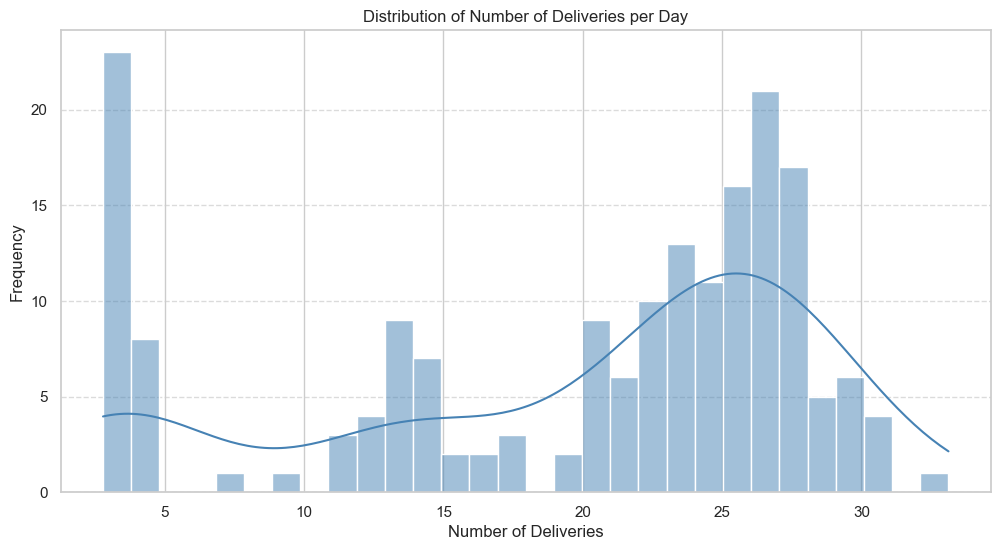

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(
    delivery_by_day["avg_delivery_count"], bins=30, kde=True, color="steelblue"
)
plt.title("Distribution of Number of Deliveries per Day")
plt.xlabel("Number of Deliveries")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()